In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


**IMPORTING IMPORTANT LIBRARIES**

In [2]:
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import KFold
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomContrast


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**DATA PREPROCESSING**

In [3]:
train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")

In [4]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
test.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


**USING LAMBDA APPLY FUNCTION TO ADD IMAGE PATH IN THE TABLE CORRESPONDING TO UNIQUE IMAGE ID**

In [6]:
train["file_path"] = train["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/train/" + identifier + ".jpg")
test["file_path"] = test["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/test/" + identifier + ".jpg")

In [7]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


In [8]:
train.columns

Index(['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity',
       'file_path'],
      dtype='object')

**THE MAIN 12 TABULAR FEATURES THAT WILL BE FED INTO ANN MODEL**

In [9]:
columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

In [10]:
image_size = 128
batch_size =128

**THIS FUNCTION DOES THE NECESSARY IMAGE PREPROCESSING BY RESIZING , SCALING ETC.**

**THE FUNCTION FOR CREATING A NEURAL NETWORK FOR TABULAR DATA**

In [11]:
def build_tabular_model(inputs):
   
    x = keras.layers.Dense(12, activation='relu')(inputs)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Concatenate()([x, inputs])
    return x

In [12]:
def block(x, filters, kernel_size, repetitions, pool_size=2, strides=2):
    for i in range(repetitions):
        x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)
    return x

In [13]:
import tensorflow as tf
from tensorflow import keras

def preprocess(image_url, tabular, image_size=224):
    # Read and preprocess the image
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to [0, 1]
    image = tf.image.resize(image, (image_size, image_size))  # Resize the image

    # Return the processed image and tabular data (excluding the first element)
    return (image, tabular[1:]), tf.cast(tabular[0], tf.float32)

**FUNCTION TO CREATE RESNET CNN FOR IMAGE DATA AND CONCATENATING WITH THE OUTPUTS OF TABULAR FEATURES CREATED BY ANN MODEL**

In [14]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, RandomContrast, RandomRotation
from tensorflow.keras.models import Model

def get_model(image_size, columns):
    image_inputs = tf.keras.Input((image_size, image_size, 3))
    tabular_inputs = tf.keras.Input(len(columns))
    
    weights_path = '/kaggle/input/resnet50-weights-h5/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    if os.path.exists(weights_path):
        resnet = ResNet50(include_top=False, weights=weights_path, pooling=None)
    else:
        print("Weights file not found. Using 'imagenet' weights.")
        resnet = ResNet50(include_top=False, weights='imagenet', pooling=None)
    image_x = resnet(RandomContrast(factor=0.1)(RandomRotation(factor=0.15)(image_inputs)))
    image_x = tf.keras.layers.GlobalAveragePooling2D()(image_x)
    
    # Assuming build_tabular_model is a function you have defined to handle tabular data
    tabular_x = build_tabular_model(tabular_inputs)
    
    x = tf.keras.layers.Concatenate(axis=1)([image_x, tabular_x])
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[image_inputs, tabular_inputs], outputs=[output])
    return model

**A PICTORIAL VIEW OF HOW THE MODEL LOOKS LIKE**

In [15]:
image_size = 224
model = get_model(image_size, columns)
#tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true -  y_pred) ** 2))

Epoch 1/300
62/62 [==============================] - ETA: 0s - loss: 499.2696 - mae: 16.5609 - rmse: 21.9210 - mape: 76.3884

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 110s 926ms/step - loss: 499.2696 - mae: 16.5609 - rmse: 21.9210 - mape: 76.3884 - val_loss: 769.8838 - val_mae: 20.0743 - val_rmse: 27.7073 - val_mape: 57.0404 - lr: 0.0010
Epoch 2/300
62/62 [==============================] - 43s 695ms/step - loss: 406.2644 - mae: 15.0498 - rmse: 20.1043 - mape: 77.9037 - val_loss: 557.7651 - val_mae: 16.0526 - val_rmse: 23.5612 - val_mape: 58.0237 - lr: 0.0010
Epoch 3/300
62/62 [==============================] - 43s 696ms/step - loss: 405.8351 - mae: 15.0786 - rmse: 20.0927 - mape: 77.7470 - val_loss: 472.4189 - val_mae: 15.0855 - val_rmse: 21.6744 - val_mape: 64.7128 - lr: 0.0010
Epoch 4/300
62/62 [==============================] - 42s 677ms/step - loss: 403.1568 - mae: 14.9883 - rmse: 20.0255 - mape: 77.5589 - val_loss: 533.8351 - val_mae: 15.6645 - val_rmse: 23.0454 - val_mape: 58.5241 - lr: 0.0010
Epoch 5/300
62/62 [==============================] - 43s 695ms/step - loss: 394.5614 - mae: 14.8272 - rmse: 19.

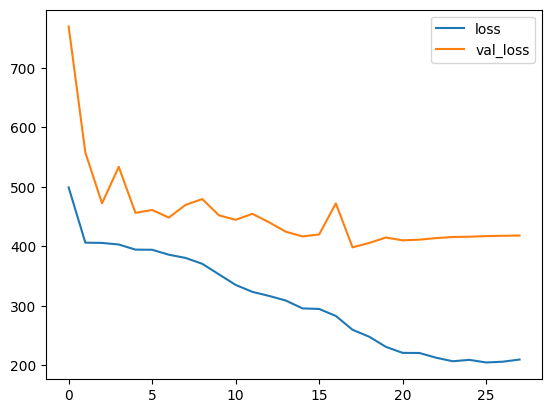

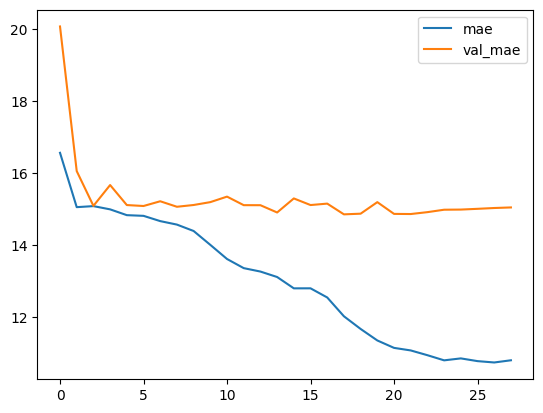

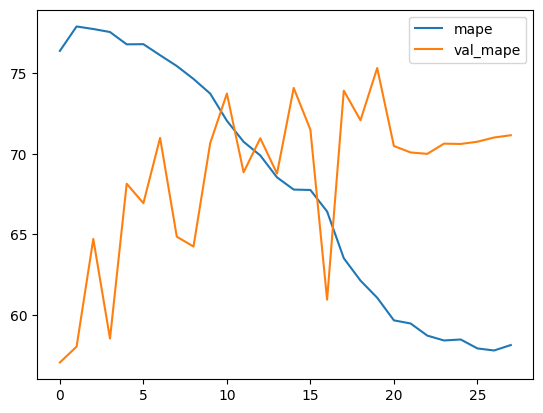

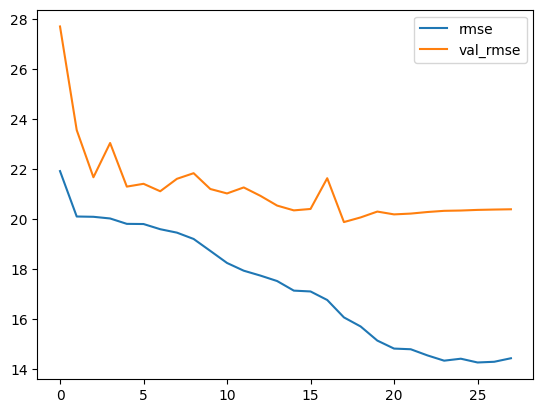

In [17]:
tf.keras.backend.clear_session()
models = []
historys = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
train_best_fold = True
best_fold = 0
for index, (train_indices, val_indices) in enumerate(kfold.split(train)):
    if train_best_fold and index != best_fold: continue
    x_train = train.loc[train_indices, "file_path"]
    tabular_train = train.loc[train_indices, ["Pawpularity"] + columns]
    x_val= train.loc[val_indices, "file_path"]
    tabular_val = train.loc[val_indices, ["Pawpularity"] + columns]
    checkpoint_path = "model_%d.h5"%(index)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
    early_stop = tf.keras.callbacks.EarlyStopping(min_delta=1e-4, patience=10)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.3,patience=2, min_lr=1e-7)
    callbacks = [early_stop, checkpoint, reduce_lr]    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, tabular_train)).map(preprocess).shuffle(512).batch(batch_size).cache().prefetch(2)
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, tabular_val)).map(preprocess).batch(batch_size).cache().prefetch(2)
    model = get_model(image_size, columns)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ["mae", rmse, "mape"])
    history = model.fit(train_ds, epochs=300, validation_data=val_ds, callbacks=callbacks, batch_size = 8)
    for metrics in [("loss", "val_loss"), ("mae", "val_mae"), ("mape", "val_mape"), ["rmse", "val_rmse"]]:
        pd.DataFrame(history.history, columns=metrics).plot()
        plt.show()
    model.load_weights(checkpoint_path)
    historys.append(history)
    models.append(model)

In [18]:
def preprocess_test_data(image_url, tabular):
    print(image_url, tabular)
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    # 0 won't be used in prediction, but it's needed in this senario or the tabular variable is treated as label.
    return (image, tabular), 0

In [19]:
test_ds = tf.data.Dataset.from_tensor_slices((test["file_path"], test[columns])).map(preprocess_test_data).batch(batch_size).cache().prefetch(2)

Tensor("args_0:0", shape=(), dtype=string) Tensor("args_1:0", shape=(12,), dtype=int64)


In [20]:
use_best_result = False
if use_best_result:
    if train_best_fold:
        best_model = models[0]
    else:
        best_fold = 0
        best_score = 10e8
        for fold, history in enumerate(historys):
            for val_rmse in history.history["val_rmse"]:
                if val_rmse < best_score:
                    best_score = val_rmse
                    best_fold = fold
        print("Best Score:%.2f Best Fold: %d"%(best_score, best_fold + 1))
        best_model = models[best_fold]
    results = best_model.predict(test_ds).reshape(-1)
else:
    total_results = []
    for model in models:
        total_results.append(model.predict(test_ds).reshape(-1))
    results = np.mean(total_results, axis=0).reshape(-1)
sample_submission["Pawpularity"] = results
sample_submission.to_csv("submission.csv", index=False)

1/1 [==============================] - 2s 2s/step
